    lambda  Task        AA       AIA        FM        IM  Overall Acc
0        0     1  0.926750  0.926750  0.000000  0.000000     0.926750
1        0     2  0.483375  0.705062  0.926750 -0.016528     0.472222
2        0     3  0.332000  0.580708  0.946750 -0.089000     0.366286
3       10     1  0.926750  0.926750  0.000000  0.000000     0.926750
4       10     2  0.482375  0.704562  0.926750 -0.014528     0.469000
5       10     3  0.332533  0.580553  0.945750 -0.090600     0.366714
6      100     1  0.926750  0.926750  0.000000  0.000000     0.926750
7      100     2  0.484250  0.705500  0.926750 -0.018278     0.470667
8      100     3  0.332667  0.581222  0.947625 -0.091000     0.366929
9     1000     1  0.926750  0.926750  0.000000  0.000000     0.926750
10    1000     2  0.484125  0.705437  0.926750 -0.018028     0.473889
11    1000     3  0.337533  0.582803  0.941000 -0.092600     0.371929
12   10000     1  0.926750  0.926750  0.000000  0.000000     0.926750
13   10000     2  0.

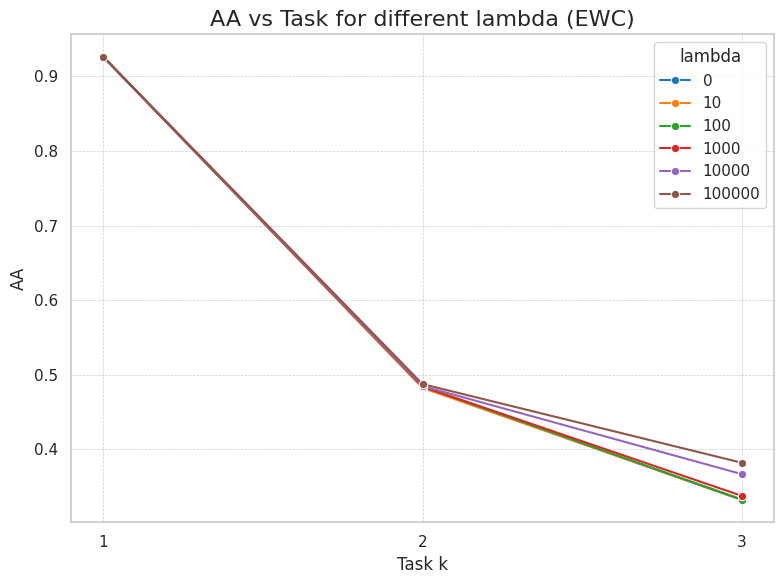

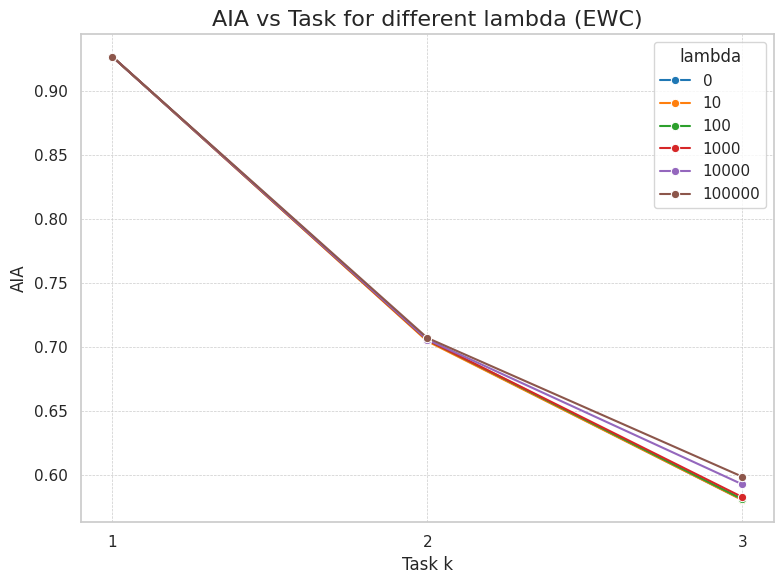

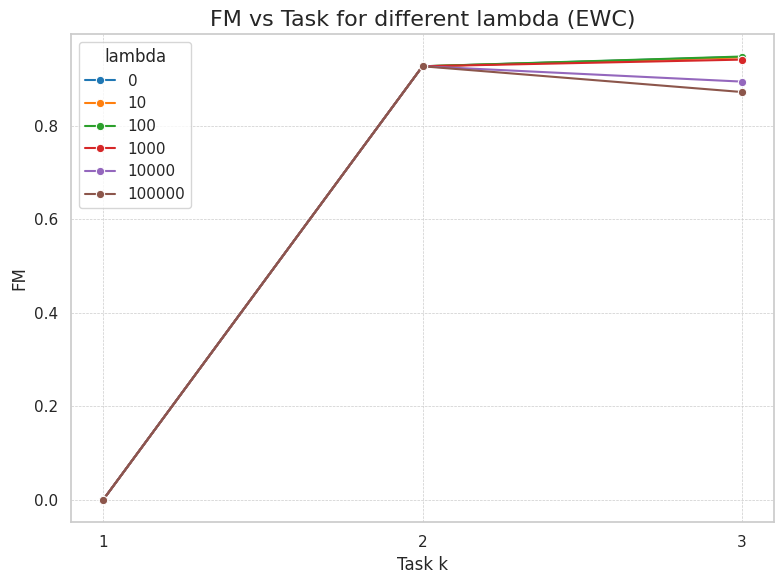

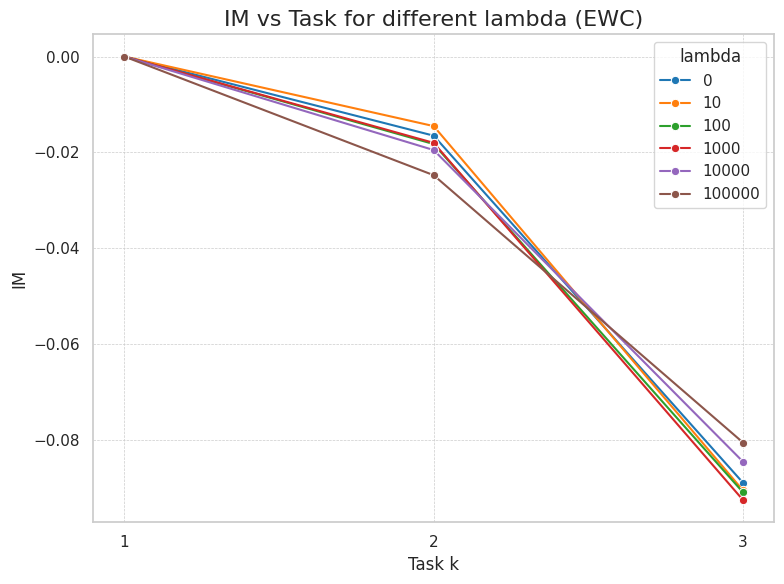

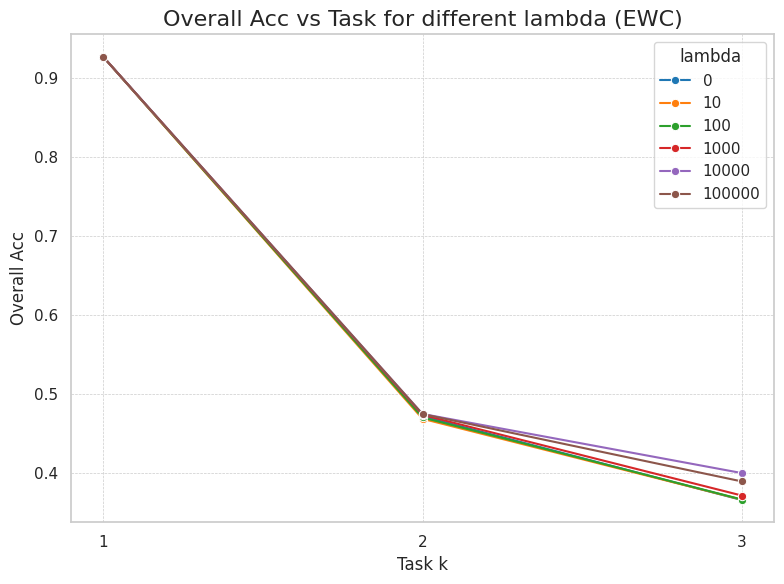

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. 指標計算関数 --- 

def compute_aa_and_aia(acc_matrix):
    AA_list, AIA_list = [], []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs)/len(current_accs) if current_accs else 0
        AA_list.append(AA_k)
        AIA_k = sum(AA_list)/len(AA_list) if AA_list else 0
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix):
    fm_list = [0.0]
    num_tasks = len(acc_matrix)
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs = [acc_matrix[l][j] for l in range(j, k) if j < len(acc_matrix[l])]
            max_past_acc = max(past_accs) if past_accs else 0
            current_acc = acc_matrix[k][j] if j < len(acc_matrix[k]) else 0
            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum/k if k>0 else 0)
    return fm_list

def compute_im(acc_matrix, joint_accs):
    im_list = []
    num_tasks = len(acc_matrix)
    for k in range(num_tasks):
        if k < len(joint_accs) and k < len(acc_matrix[k]):
            im_list.append(joint_accs[k] - acc_matrix[k][k])
        else:
            im_list.append(np.nan)
    return im_list

# --- 2. CSV 読み込み & 指標計算 --- 

base_dir = "/work/csv/uci-har/cil_each/ewc"
joint_base_dir = "/work/csv/uci-har/cil_each/ncp"
joint_dir = os.path.join(joint_base_dir, "joint")
lambda_values = [0, 10, 100, 1000, 10000, 100000]
seeds = [1, 2, 3, 4, 5]
num_tasks = 3

results = []

for lam in lambda_values:
    acc_matrices_per_seed = []
    joint_accs_per_seed = []
    overall_accs_per_seed = []
    for seed in seeds:
        file_path = os.path.join(base_dir, f"lambda{lam}", f"seed{seed}.csv")
        joint_file_path = os.path.join(joint_dir, f"seed{seed}.csv")

        if not os.path.exists(file_path) or not os.path.exists(joint_file_path):
            print(f"Missing CSV: {file_path} or {joint_file_path}")
            continue

        df = pd.read_csv(file_path)
        df_joint = pd.read_csv(joint_file_path)

        # --- 2回目 inference の抽出 ---
        inf2_df = df.groupby('task').nth(1)  # 各タスク2行目
        overall_accs = inf2_df['テスト精度 (Test Acc)'].tolist()
        overall_accs_per_seed.append(overall_accs)
        df_filtered = df.drop(index=inf2_df.index)

        # --- acc_matrix 構築 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        acc_matrix = []
        idx = 0
        for k in range(num_tasks):
            row = acc_list[idx: idx + k + 1]
            acc_matrix.append(row)
            idx += k + 1
        acc_matrices_per_seed.append(acc_matrix)

        # --- joint acc ---
        joint_accs = df_joint['テスト精度 (Test Acc)'].head(num_tasks).tolist()
        joint_accs_per_seed.append(joint_accs)

    if not acc_matrices_per_seed:
        continue

    # --- seed 平均 ---
    # acc_matrix 平均を作成
    max_len = max(len(m) for m in acc_matrices_per_seed)
    acc_matrix_avg = []
    for k in range(num_tasks):
        rows = []
        for m in acc_matrices_per_seed:
            if k < len(m):
                rows.append(m[k])
        if rows:
            row_len = max(len(r) for r in rows)
            row_avg = []
            for j in range(row_len):
                vals = [r[j] for r in rows if j < len(r)]
                row_avg.append(sum(vals)/len(vals) if vals else np.nan)
            acc_matrix_avg.append(row_avg)

    # joint 平均
    joint_accs_avg = []
    for t in range(num_tasks):
        vals = [lst[t] for lst in joint_accs_per_seed if t < len(lst)]
        joint_accs_avg.append(sum(vals)/len(vals) if vals else np.nan)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)

    # --- 指標計算 ---
    aa_list, aia_list = compute_aa_and_aia(acc_matrix_avg)
    fm_list = compute_fm(acc_matrix_avg)
    im_list = compute_im(acc_matrix_avg, joint_accs_avg)

    for k in range(num_tasks):
        results.append({
            'lambda': lam,
            'Task': k+1,
            'AA': aa_list[k],
            'AIA': aia_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Overall Acc':  overall_acc_avg[k] if k < len(overall_acc_avg) else np.nan
        })

metrics_df = pd.DataFrame(results)
print(metrics_df)

# --- 3. 可視化 --- 

sns.set(style="whitegrid")
indicators = ["AA", "AIA", "FM", "IM", "Overall Acc"]

for ind in indicators:
    plt.figure(figsize=(8,6))
    sns.lineplot(data=metrics_df, x="Task", y=ind, hue="lambda", marker="o", palette="tab10")
    plt.title(f"{ind} vs Task for different lambda (EWC)", fontsize=16)
    plt.xlabel("Task k", fontsize=12)
    plt.ylabel(ind, fontsize=12)
    plt.xticks(range(1, num_tasks+1))
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(title="lambda")
    plt.tight_layout()
    plt.show()
